Project: # Patil_ADEarlyDetection

# **Phase 1:**  
## CNN with TL = Inception2





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/My Drive/AD_proj"

Mounted at /content/drive
ad_proj_try1.ipynb  ad_proj_try2.ipynb	Alzheimer_s_Dataset  my_best_models


In [ ]:
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, save_model
from keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Base Model - Tranfer Layer
from keras.applications.densenet import DenseNet169, DenseNet121, DenseNet201 #https://keras.io/api/applications/densenet/
from keras.applications import VGG16, VGG19 #https://keras.io/api/applications/vgg/
from keras.applications import InceptionV3 #https://www.tensorflow.org/api_docs/python/tf/keras/applications/InceptionV3
from keras.applications import ResNet152V2
#from keras.applications.vgg19 import preprocess_input
#from keras.applications.resnet50 import preprocess_input
#from keras.applications.inception_v3 import preprocess_input

import numpy as np
import itertools

# Plot libs
from matplotlib import pyplot as plt
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#import sys
#sys.path.append('/content/drive/My Drive/AD_proj')

#my helper functions
#import ad_helper_functions
#ad_helper_functions.ad_proj_help()

#
# Define constants
#
NUM_EPOCH =  100
NUM_PATIENCE =  20

NUM_BATCH_SIZE = 128
NUM_IMAGE_SIZE =224
NUM_VAL_SPLIT = 0.2
NUM_IMG_RESCALE = 1/255
NUM_LEARNING_RATE = 0.001 #Choose form [1e-2, 1e-3, 1e-4]

# To prevent overfitting
NUM_DROPOUT_RATE=0.5
NUM_FILL_GRAY = 125.0

# Tranfer Layer Base Model choice
NUM_CHOICE_INCEPTION_V3 = 1
NUM_CHOICE_VGG16 = 2
NUM_CHOICE_VGG19 = 3
NUM_CHOICE_DENSENET121 = 4
NUM_CHOICE_DENSENET169 = 5
NUM_CHOICE_DENSENET201 = 6
NUM_CHOICE_RESNET152V2 =7

target_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [ ]:
#
# DATA AUGMENTATION:  
# Augment the train data to make sure each EPOCH does NOT train on same image
# i.e. train data will be augmented on every epoch
#
train = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=NUM_VAL_SPLIT,
                           rotation_range=40,
                           zoom_range=NUM_VAL_SPLIT,
#                           width_shift_range=NUM_VAL_SPLIT, 
#                           height_shift_range=NUM_VAL_SPLIT,
#                           fill_mode='constant', 
#                           cval=NUM_FILL_GRAY,                            
                           horizontal_flip=True, 
                           vertical_flip=True, 
                           rescale=NUM_IMG_RESCALE)

val = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=NUM_VAL_SPLIT, rescale=NUM_IMG_RESCALE)
test = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=NUM_VAL_SPLIT, rescale=NUM_IMG_RESCALE)

train_dataset = train.flow_from_directory(
    '/content/drive/My Drive/AD_proj/Alzheimer_s_Dataset/train', 
    target_size=(NUM_IMAGE_SIZE, NUM_IMAGE_SIZE), 
    batch_size=NUM_BATCH_SIZE, 
    class_mode='categorical', 
    subset='training')

val_dataset = val.flow_from_directory(
    '/content/drive/My Drive/AD_proj/Alzheimer_s_Dataset/train', 
    target_size=(NUM_IMAGE_SIZE, NUM_IMAGE_SIZE), 
    batch_size=NUM_BATCH_SIZE, 
    class_mode='categorical', 
    subset='validation')

test_dataset = test.flow_from_directory(
    '/content/drive/My Drive/AD_proj/Alzheimer_s_Dataset/test', 
    target_size=(NUM_IMAGE_SIZE, NUM_IMAGE_SIZE), 
    batch_size=NUM_BATCH_SIZE, 
    class_mode='categorical')

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
# All Helper functions
#--------------------------------------------------------------------
# Function Name: f_ad_model_builder
# Description: Build Convolutional Neural Network (CNN) Deep learning model
#              for early diagnosis of Alzheimer's disease
#--------------------------------------------------------------------
def f_ad_model_builder():

  # ---------------------------------------------------
  # Base model as Tranfer Layer model
  # Chose include_top=False, so fully-connected output layers of the model used 
  # to make predictions is not loaded, allowing a new output layer to be added and trained
  #model_densenet169 = DenseNet169(input_shape=(NUM_IMAGE_SIZE,NUM_IMAGE_SIZE,3), include_top=False, weights="imagenet")
  #model_vgg19 = VGG19(input_shape=(NUM_IMAGE_SIZE,NUM_IMAGE_SIZE,3), include_top=False, weights="imagenet")
  model_inceptionv3 = InceptionV3(input_shape=(NUM_IMAGE_SIZE,NUM_IMAGE_SIZE,3), include_top=False, weights="imagenet")

  # freeze layers
  for layer in model_inceptionv3.layers :
    layer.trainable = False

  model = Sequential() # seq model is a linear stacks of layers
  model.add(model_inceptionv3)
  # -------------------------------------------------

  # Dropout to prevent overfitting
  # Train model on some layer outputs are randomly ignored or “dropped out.” 
  # This has the effect of making the layer look-like and be treated-like a layer with a different 
  # number of nodes and connectivity to the prior layer.
  #model.add(Dropout(rate=NUM_DROPOUT_RATE))
  model.add(Dropout(rate=0.5))

  # Flatten: Rectangular or cubic shapes can't be direct inputs & connected layer. 
  # We flatten the output of the convolutional layers to create a 1-dimentional array (single long feature vector)
  model.add(Flatten())

  # Dense Layer 1 
  model.add(BatchNormalization()) # Batch Normalization: to imporve the training speed
  model.add(Dense(units=2048, kernel_initializer='he_uniform'))

  # Dense Layer 2
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  #model.add(Dropout(rate=NUM_DROPOUT_RATE))
  model.add(Dropout(rate=0.5))
  model.add(Dense(units=1024, kernel_initializer='he_uniform'))

  # Final Dense Layer
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  #model.add(Dropout(rate=NUM_DROPOUT_RATE))
  model.add(Dropout(rate=0.5))
  model.add(Dense(units=4, activation='softmax'))

  # printout whole model: Hidden layer + Dense Layer
  model.summary()
 
  #
  # COMPILE: Choose learning rate from 0.01, 0.001, or 0.0001 i.e. [1e-2, 1e-3, 1e-4]
  # Optimizer: optimizers shape and mold your model into its most accurate possible form by manipulating weights
  model.compile(optimizer = keras.optimizers.Adam(learning_rate = NUM_LEARNING_RATE),
                loss = 'categorical_crossentropy', 
                metrics = [tf.keras.metrics.AUC(name = 'auc')])
  
  return model

#--------------------------------------------------------------------
# Function Name: f_ad_plot_auc_loss
# Description: 
#--------------------------------------------------------------------
def f_ad_plot_auc_loss(f_model):

  # create subplots
  fig, axs = plt.subplots(1,2,figsize=(15,10))

  ticks = np.arange(1,len(f_model.history['loss'])+1)
  history_auc_length = len(f_model.history['auc'])+1
  history_val_auc_length = len(f_model.history['val_auc'])+1
  history_loss_length = len(f_model.history['loss'])+1
  history_val_loss_length = len(f_model.history['val_loss'])+1

  # Summarize history for auc
  axs[0].plot(range(1,history_auc_length), f_model.history['auc'])
  axs[0].plot(range(1,history_val_auc_length), f_model.history['val_auc'])
  axs[0].set_title('Model AUC')
  axs[0].set_ylabel('AUC')
  axs[0].set_xlabel('Epoch')
  axs[0].set_xticks(ticks,len(f_model.history['auc'])/10)
  axs[0].legend(['train', 'val'], loc='best', bbox_to_anchor=(1,1))

  # Summarize history for loss
  axs[1].plot(range(1, history_loss_length), f_model.history['loss'])
  axs[1].plot(range(1,history_val_loss_length), f_model.history['val_loss'])
  axs[1].set_title('Model Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].set_xticks(ticks,len(f_model.history['loss'])/10)
  axs[1].legend(['train', 'val'], loc='best', bbox_to_anchor=(1,1))


#--------------------------------------------------------------------
# Function Name: plot_confusion_matrix
# Description: 
# source code from : scikit-learn.org
#--------------------------------------------------------------------
def f_ad_plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

#--------------------------------------------------------------------
# Function Name: f_all_ad_plot_model
# Description: 
#--------------------------------------------------------------------
def f_ad_all_plot_model(hist):

    plt.plot(hist.history["acc"])
    plt.plot(hist.history['val_acc'])
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("AD Early Detection Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Training Accuracy","Validation Accuracy","Training loss","Validation Loss"])

    # Show the plot
    plt.show()

#--------------------------------------------------------------------
# Function Name: f_ad_plot_model_acc_loss
# Description: 
#              
#--------------------------------------------------------------------
def f_ad_plot_acc_loss(f_model):

    # Create sub-plots
    fig, axs = plt.subplots(1,2,figsize=(15,10))
    ticks = np.arange(1,len(f_model.history['loss'])+1)
    history_acc_length = len(f_model.history['accuracy'])+1
    history_val_accuracy_length = len(f_model.history['val_accuracy'])+1
    history_loss_length = len(f_model.history['loss'])+1
    history_val_loss_length = len(f_model.history['val_loss'])+1

    # Summarize history for accuracy
    axs[0].plot(range(1,history_acc_length), f_model.history['accuracy'])
    axs[0].plot(range(1,history_val_accuracy_length), f_model.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(ticks,len(f_model.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Summarize history for loss
    axs[1].plot(range(1, history_loss_length), f_model.history['loss'])
    axs[1].plot(range(1,history_val_loss_length), f_model.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(ticks,len(f_model.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    
    # Show the plot
    plt.show()

#--------------------------------------------------------------------
# Function Name: 
# Description: 
#              
#--------------------------------------------------------------------
# ??? how to calculate fpr/tpr
def f_ad_plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, 'b',color='orange', label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate (FPR) ')
    plt.ylabel('True Positive Rate (TPR) ')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc = 'lower right')
    plt.show()



87916544/87910968 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
batch_normalization_97 (Batc (None, 51200)             204800    
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              104859648 
_________________________________________________________________
batch_normalization_98 (Batc (None, 2048)              8192      
_______________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:116: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


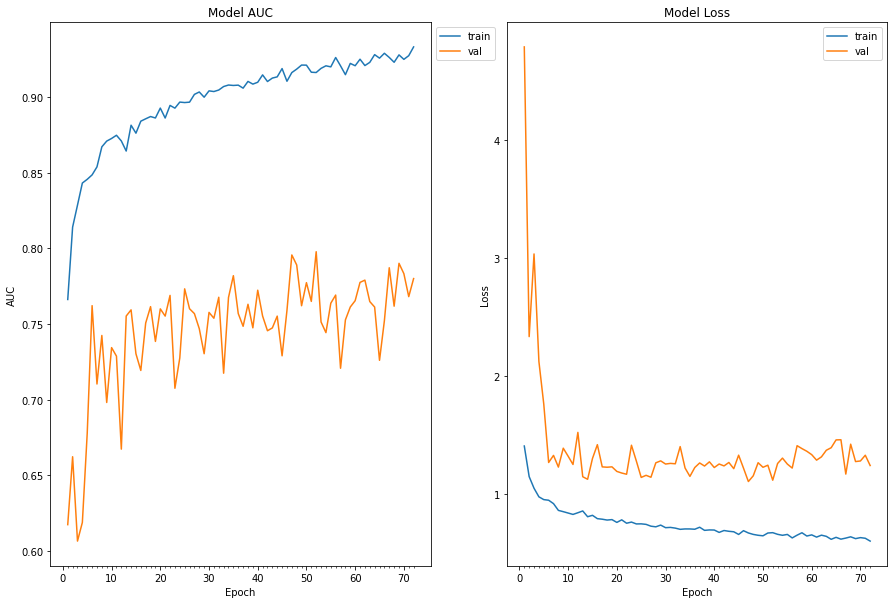

In [ ]:
# build model with Choice of base Model
model = f_ad_model_builder()

# Define callbacks
checkpoint = ModelCheckpoint("/content/drive/My Drive/AD_proj/my_best_models/inceptionV3_rev0.hdf5", monitor='val_auc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_auc', min_delta=0, patience=NUM_PATIENCE, verbose=1, mode='max') 

model_history=model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs = NUM_EPOCH,
                        callbacks = [checkpoint, early],
                        verbose = 2)

print('--------------------------------------------\n')
print('Results [with inceptionV3] :')
f_ad_plot_auc_loss(model_history)

In [ ]:
print(f"Loss: {model_history.history['loss']} " )
print(f"Val Loss: {model_history.history['val_loss']} " )
print(f"AUC: {model_history.history['auc']} " )
print(f"Val AUC: {model_history.history['val_auc']} " )

Loss: [1.409033179283142, 1.1501920223236084, 1.0516966581344604, 0.9791933298110962, 0.9557023048400879, 0.9504865407943726, 0.9216198325157166, 0.8645621538162231, 0.8537304401397705, 0.8421087265014648, 0.8304466009140015, 0.8446103930473328, 0.8597493171691895, 0.810924232006073, 0.8228000402450562, 0.7946014404296875, 0.7899901270866394, 0.7827392220497131, 0.7865018248558044, 0.7629343271255493, 0.7845558524131775, 0.7559516429901123, 0.7656430006027222, 0.7499985098838806, 0.7506933808326721, 0.7462338209152222, 0.7309209108352661, 0.7255468368530273, 0.7400739192962646, 0.718304455280304, 0.7206315398216248, 0.7145138382911682, 0.7043055891990662, 0.7075977325439453, 0.7074893116950989, 0.7050689458847046, 0.7220101952552795, 0.6956879496574402, 0.6992076635360718, 0.6983575820922852, 0.678327202796936, 0.6942689418792725, 0.6876908540725708, 0.6836816668510437, 0.6610847115516663, 0.6928688287734985, 0.673611581325531, 0.6613990068435669, 0.6540013551712036, 0.6494953036308289

Evaluate on test data
10/10 [==============================] - 132s 13s/step - loss: 2.0250 - auc: 0.7107
test loss, test acc: [2.0249671936035156, 0.7106736302375793]
-----------------------------------------------------
Classification Report [test DataSet]
                  precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.64      0.01      0.02       640
VeryMildDemented       0.35      1.00      0.52       448

        accuracy                           0.35      1279
       macro avg       0.25      0.25      0.14      1279
    weighted avg       0.44      0.35      0.19      1279

-----------------------------------------------------
Confusion matrix, without normalization
[[  0   0   2 177]
 [  0   0   0  12]
 [  0   0   7 633]
 [  0   0   2 446]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


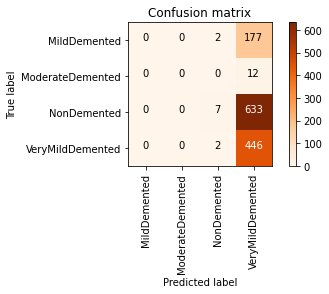

In [ ]:
#
# load model
#
loaded_model = load_model(filepath='/content/drive/My Drive/AD_proj/my_best_models/inceptionV3_rev0.hdf5')

print("Evaluate on test data")
test_results = loaded_model.evaluate(test_dataset, batch_size=NUM_BATCH_SIZE)
print("test loss, test auc:", test_results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
test_pred = loaded_model.predict(test_dataset)
test_pred_classes = np.argmax(test_pred, axis=1)

#print ('-----------------------------------------------------')
#print('Confusion Matrix [test DataSet]')
cm = confusion_matrix(test_dataset.classes, test_pred_classes)

print ('-----------------------------------------------------')
print('Classification Report [test DataSet]')
print(classification_report(test_dataset.classes, test_pred_classes, target_names=target_names))

print ('-----------------------------------------------------')
#plot the matrix
f_ad_plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion matrix', cmap=plt.cm.Oranges)

Normalized confusion matrix
[[0.         0.         0.01117318 0.98882682]
 [0.         0.         0.         1.        ]
 [0.         0.         0.0109375  0.9890625 ]
 [0.         0.         0.00446429 0.99553571]]


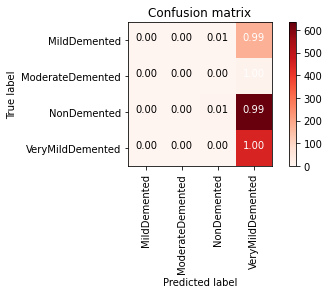

In [ ]:
#plot the matrix
plot_confusion_matrix(cm, target_names, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds)

-----------------------------------------------------
Confusion Matrix [Val DataSet]
-----------------------------------------------------
Classification Report [Val DataSet]
                  precision    recall  f1-score   support

    MildDemented       0.11      0.08      0.09       143
ModerateDemented       0.00      0.00      0.00        10
     NonDemented       0.50      0.39      0.44       512
VeryMildDemented       0.34      0.47      0.39       358

        accuracy                           0.37      1023
       macro avg       0.24      0.24      0.23      1023
    weighted avg       0.38      0.37      0.37      1023

-----------------------------------------------------
Confusion matrix, without normalization
[[ 12   3  51  77]
 [  3   0   2   5]
 [ 55   8 199 250]
 [ 40   2 147 169]]


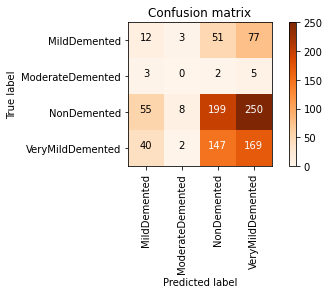

In [ ]:
#Confusion Matrix and Classification Report

predicted_classes_labels = np.argmax(predictions, axis=1)

print ('-----------------------------------------------------')
print('Confusion Matrix [Val DataSet]')
cm = confusion_matrix(val_dataset.classes, predicted_classes_labels)
#print (f"cm= {cm}" )
#print(val_dataset.classes.shape)
#print(predicted_classes_labels.shape)
print ('-----------------------------------------------------')
print('Classification Report [Val DataSet]')
print(classification_report(val_dataset.classes, predicted_classes_labels, target_names=target_names))
print ('-----------------------------------------------------')
#plot the matrix
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion matrix', cmap=plt.cm.Oranges)